In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import math

In [3]:
df = pd.read_excel('Nile.xlsx')
df = df.rename(columns={'Unnamed: 0': 'year'})
df

,year,Nile
0,1871,1120
1,1872,1160
2,1873,963
3,1874,1210
4,1875,1160
...,...,...
95,1966,746
96,1967,919
97,1968,718
98,1969,714


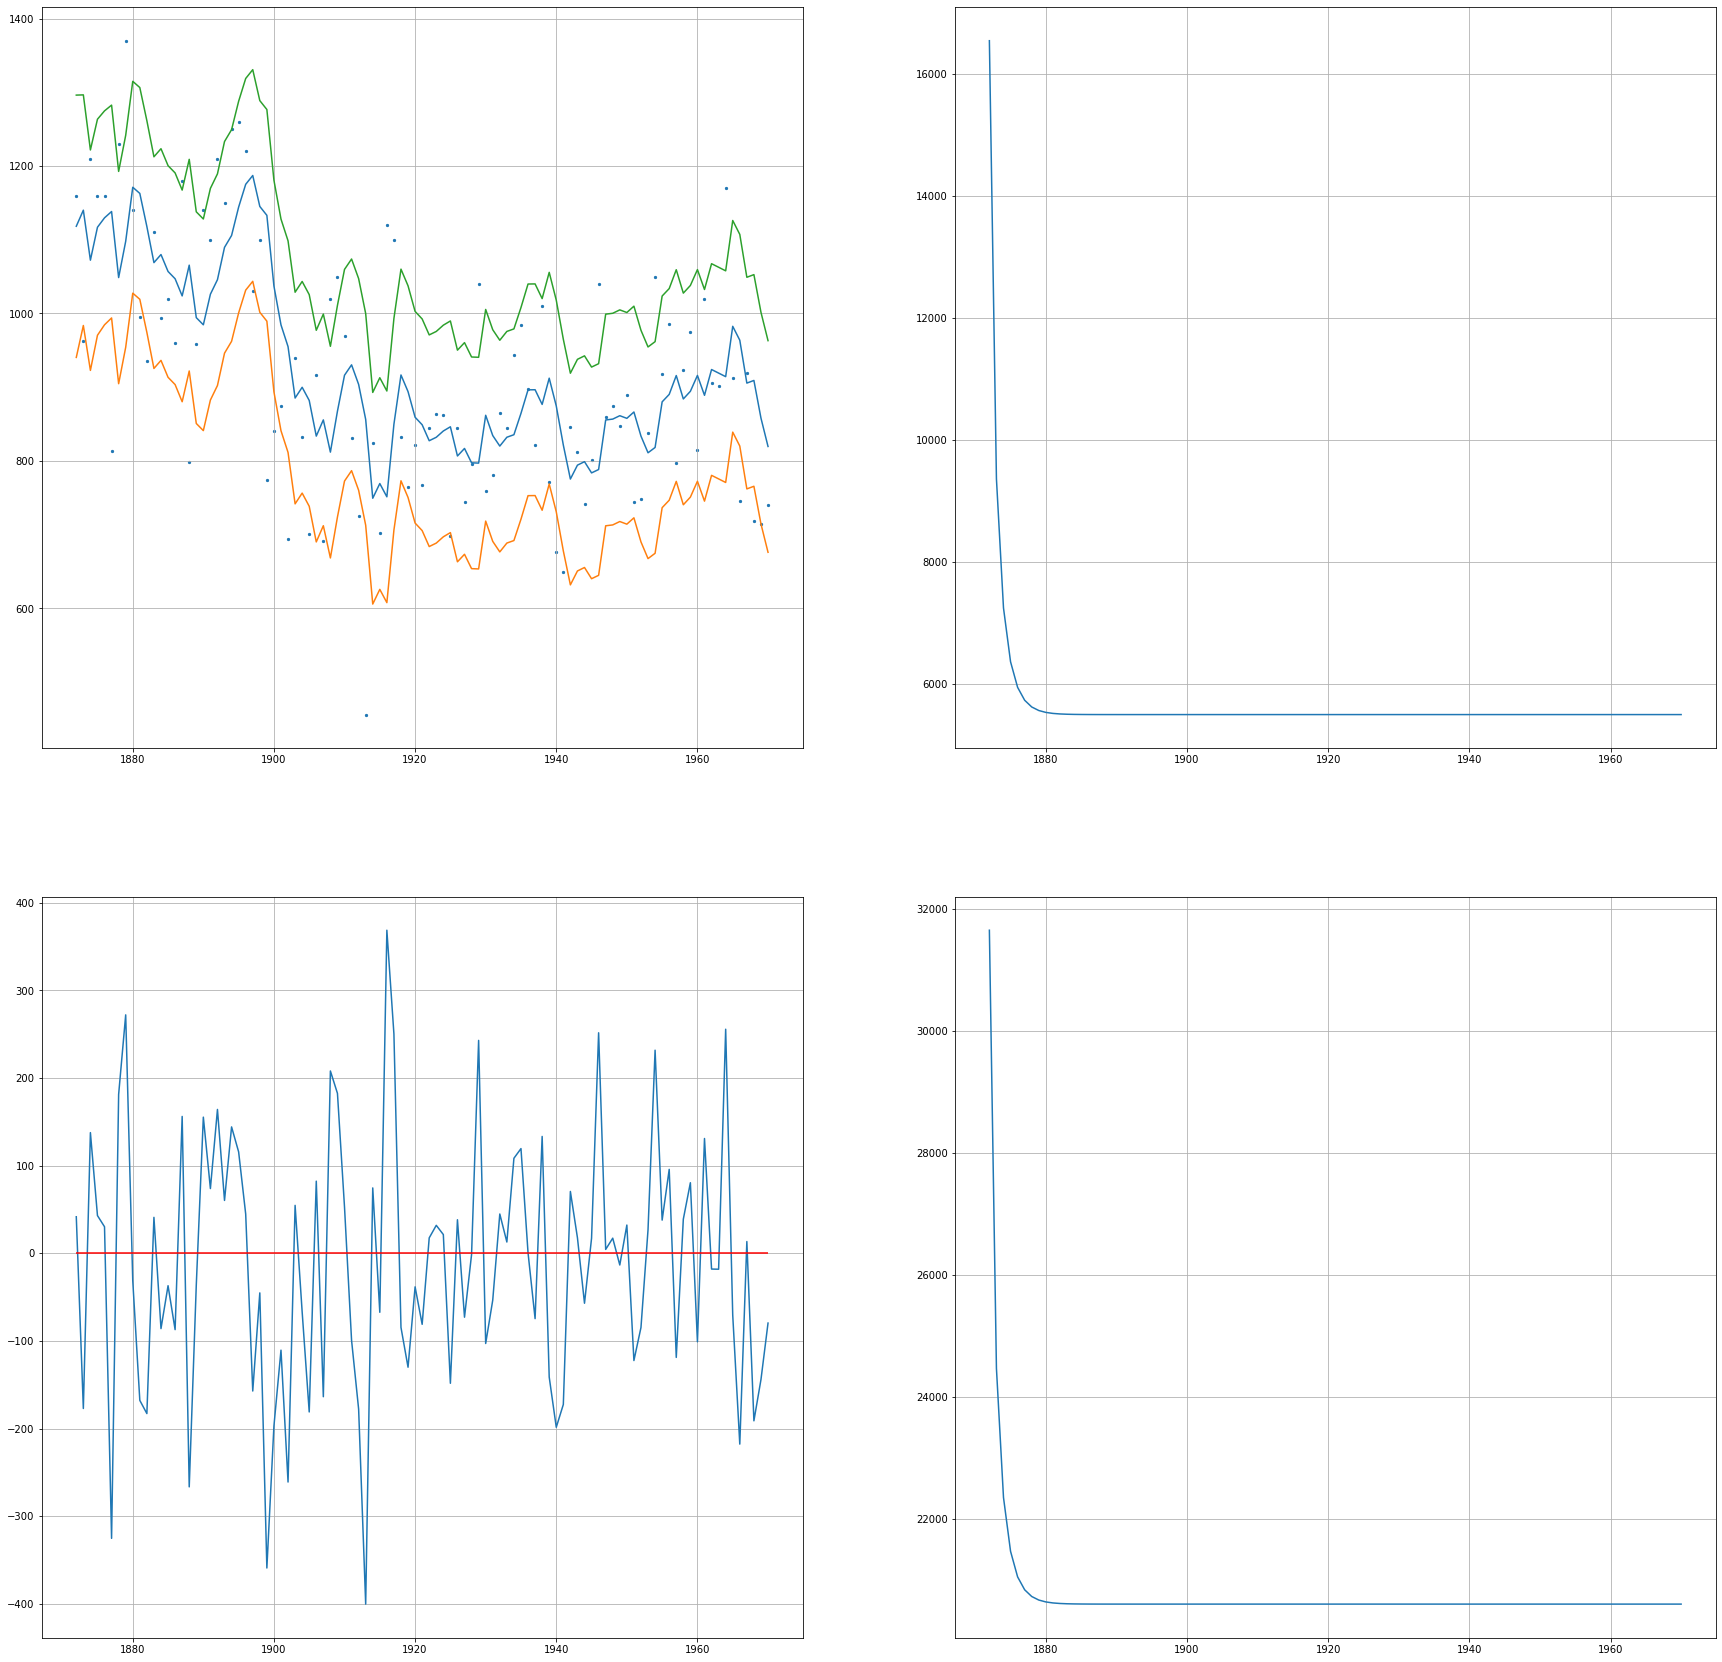

In [33]:
def Kalman_filter(df, P1, a1, sigma_e, sigma_n):
    a = a1
    P = P1

    df_kf = pd.DataFrame(columns=['a', 'P', 'v', 'F', 'K', 'ci', 'year', 'Nile'])
    df_kf.loc[0] = [np.nan, np.nan, np.nan, np.nan, np.nan,np.nan, np.nan, np.nan]
    for i,y in enumerate(df['Nile']):
        v = y - a
        F = P + sigma_e
        K = P/F
        row = [a, P, v, F, K, F**0.5, df['year'][i], df['Nile'][i]]

        att = a + K*v
        Ptt = P*(1 - K) 

        a_pred = att
        P_pred = Ptt + sigma_n

        a = a_pred
        P = P_pred
        if i > 0:
            df_kf.loc[i] = row

    return df_kf

df_kf = Kalman_filter(df=df, P1=1e7, a1=0, sigma_e = 15099, sigma_n = 1469.1)
fig, axs = plt.subplots(2,2, figsize=(30,30))

# upper left
ax = axs[0,0]
ax.scatter(df_kf['year'][:], df_kf['Nile'][:], s=5)
ax.plot(df_kf['year'][:], df_kf['a'][:])
ax.plot(df_kf['year'][:], df_kf['a'][:]-df_kf['ci'][:])
ax.plot(df_kf['year'][:], df_kf['a'][:]+df_kf['ci'][:])
#ax.set_ylim(500, 1500)

# lower left
ax = axs[1,0]
ax.plot(df_kf['year'][:], df_kf['v'][:])
ax.hlines(y = 0, xmin= df_kf['year'].min(), xmax=df_kf['year'].max(), color = 'r', linestyle = '-')

# upper right
ax = axs[0,1]
ax.plot(df_kf['year'][:], df_kf['P'][:])


# lower right
ax = axs[1,1]
ax.plot(df_kf['year'][:], df_kf['F'][:])

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass


In [34]:
df_kf

,a,P,v,F,K,ci,year,Nile
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1118.311462,16545.336391,41.688538,31644.336391,0.522853,177.888550,1872.0,1160.0
2,1140.108439,9363.657531,-177.108439,24462.657531,0.382774,156.405427,1873.0,963.0
3,1072.316018,7248.597378,137.683982,22347.597378,0.324357,149.491128,1874.0,1210.0
4,1116.974768,6366.564813,43.025232,21465.564813,0.296594,146.511313,1875.0,1160.0
...,...,...,...,...,...,...,...,...
95,963.752506,5501.257942,-217.752506,20600.257942,0.267048,143.527900,1966.0,746.0
96,905.602132,5501.257942,13.397868,20600.257942,0.267048,143.527900,1967.0,919.0
97,909.180006,5501.257942,-191.180006,20600.257942,0.267048,143.527900,1968.0,718.0
98,858.125766,5501.257942,-144.125766,20600.257942,0.267048,143.527900,1969.0,714.0


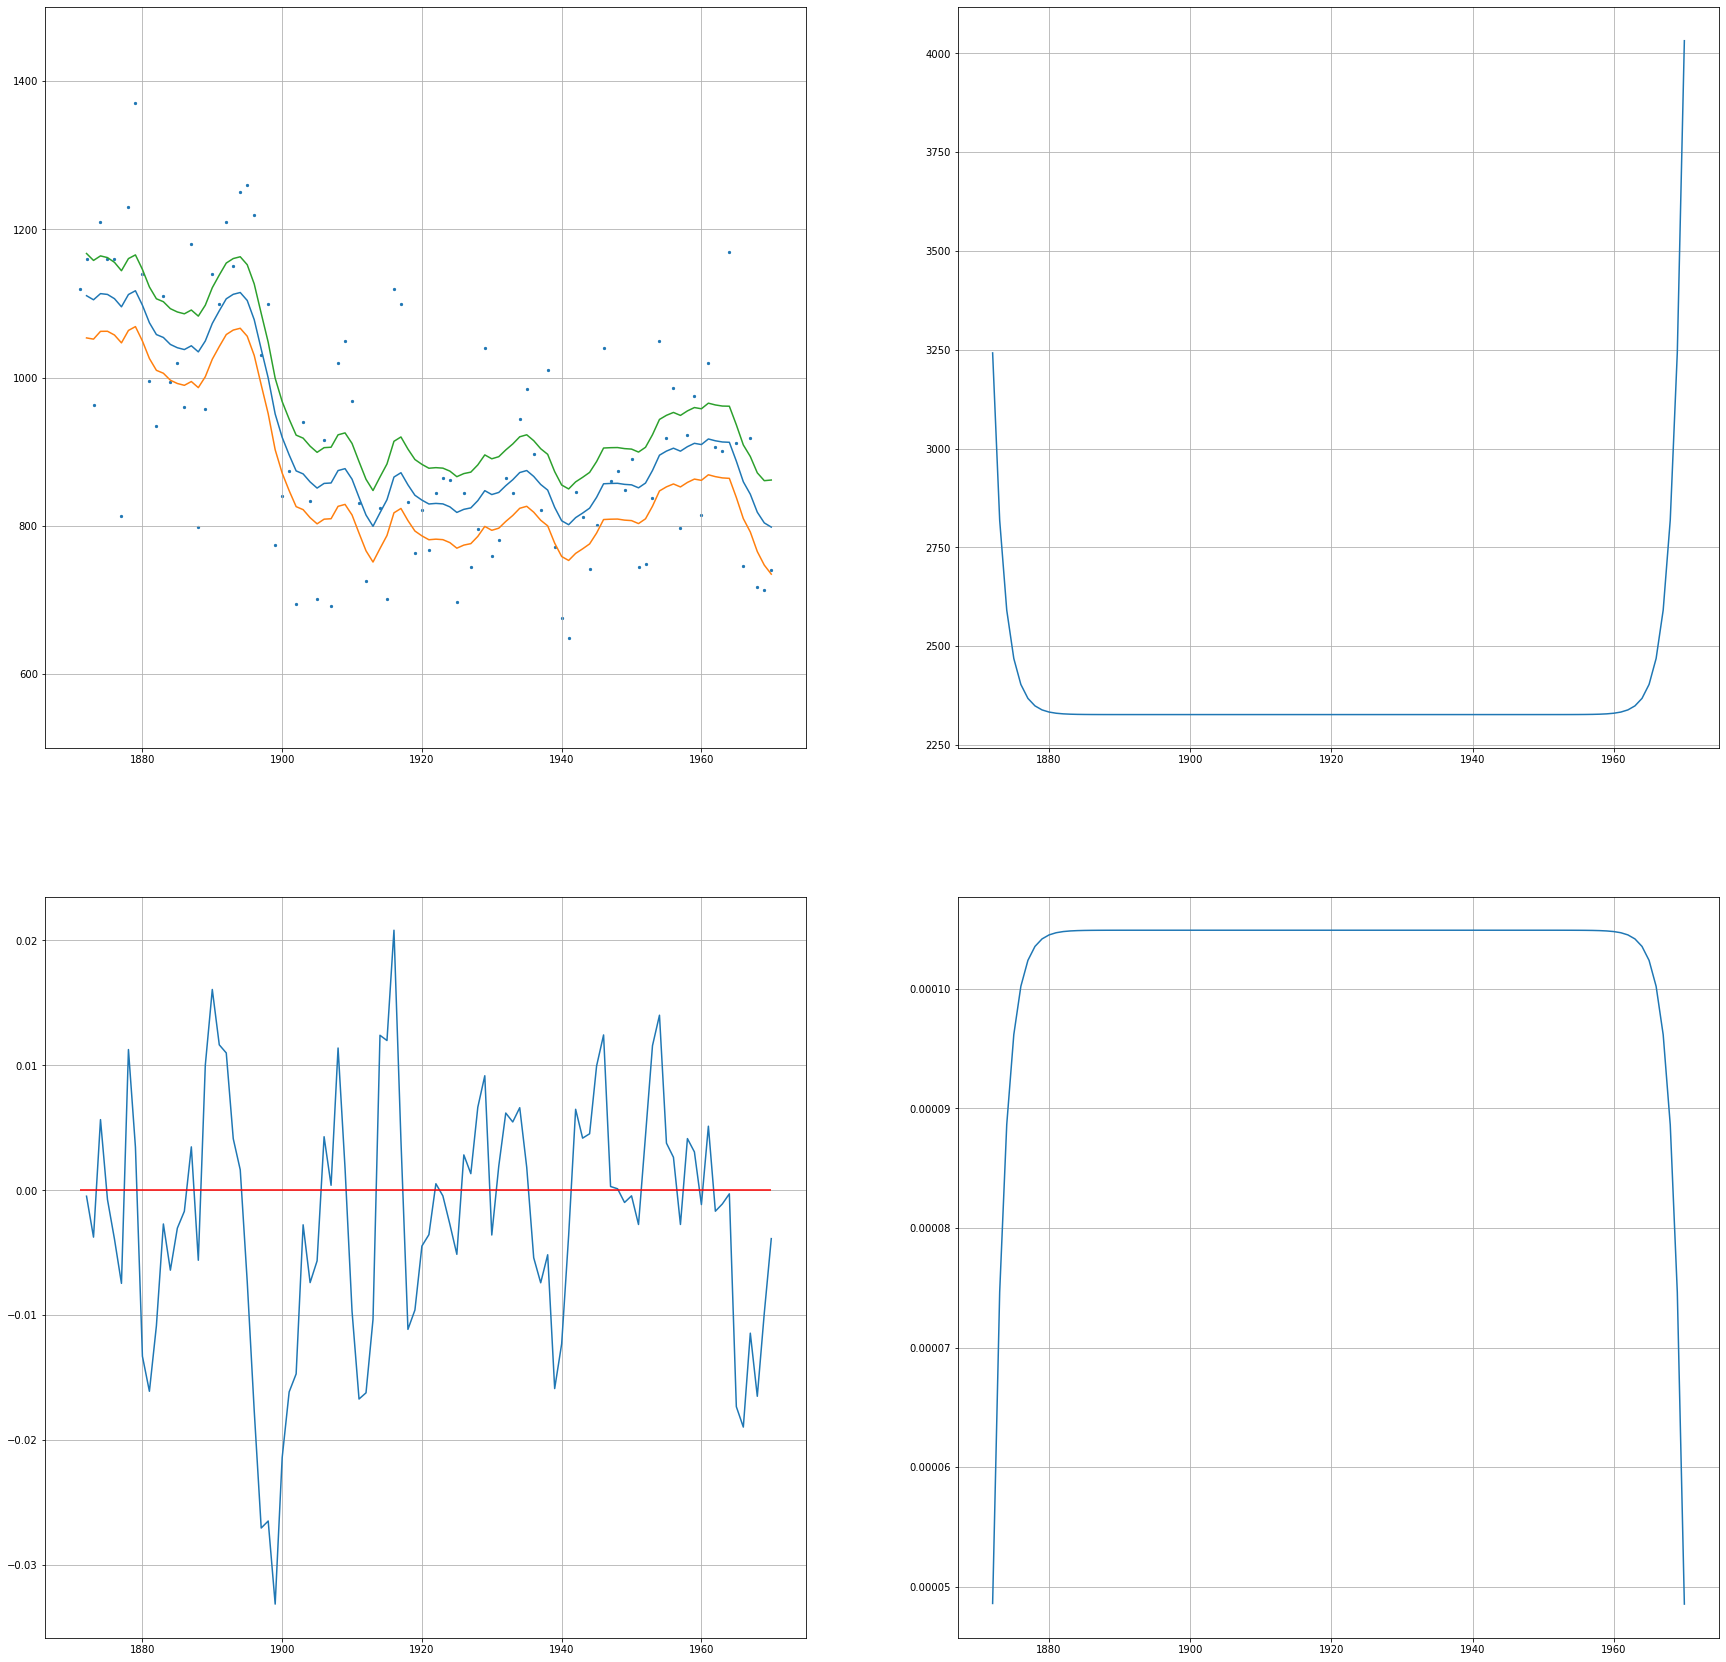

In [35]:
def Kalman_smoother(df, P1, a1, sigma_e, sigma_n, r_int, N_int):
    df_kf = Kalman_filter(df, P1, a1, sigma_e, sigma_n)
    
    # df_kf = df_kf.reindex(index=df_kf.index[::-1]).reset_index(drop=True)
    df_kf = df_kf.iloc[::-1].reset_index(drop=True)
    df_ks = pd.DataFrame(columns=['r', 'alpha', 'N', 'V', 'err', 'year', 'Nile'])

    r = r_int
    N = N_int
    for i in range(len(df_kf)):
        r = df_kf['F'][i]**-1 * df_kf['v'][i] + (1-df_kf['K'][i])*r
        alpha = df_kf['a'][i] + df_kf['P'][i]*r
        N = df_kf['F'][i]**-1 + (1-df_kf['K'][i])**2 * N
        V = df_kf['P'][i] - df_kf['P'][i]**2 * N

        row = [r, alpha, N, V, V**0.5, df_kf['year'][i], df_kf['Nile'][i]]
        df_ks.loc[i] = row

    # df_ks = df_ks.reindex(index=df_kf.index[::-1]).reset_index(drop=True)
    df_ks = df_ks.iloc[::-1].reset_index(drop=True)
    return df_ks

df_ks = Kalman_smoother(df=df, P1=10**7, a1=0, sigma_e = 15099, sigma_n = 1469.1, r_int = 0, N_int = 0)


fig, axs = plt.subplots(2,2, figsize=(30,30))

# upper left
ax = axs[0,0]
ax.scatter(df['year'], df['Nile'], s=5)
ax.plot(df_ks['year'], df_ks['alpha'])
ax.plot(df_ks['year'], df_ks['alpha']-df_ks['err'])
ax.plot(df_ks['year'], df_ks['alpha']+df_ks['err'])
ax.set_ylim(500, 1500)

# lower left
ax = axs[1,0]
ax.plot(df_ks['year'][:], df_ks['r'][:])
ax.hlines(y = 0, xmin= df['year'].min(), xmax=df['year'].max(), color = 'r', linestyle = '-')

# upper right
ax = axs[0,1]
ax.plot(df_ks['year'], df_ks['V'])


# lower right
ax = axs[1,1]
ax.plot(df_ks['year'], df_ks['N'])

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass


In [36]:
df_ks

,r,alpha,N,V,err,year,Nile
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.000470,1110.529257,0.000049,3242.056999,56.939064,1872.0,1160.0
2,-0.003747,1105.024860,0.000075,2818.473138,53.089294,1873.0,963.0
3,0.005659,1113.339175,0.000089,2590.916003,50.901041,1874.0,1210.0
4,-0.000742,1112.248601,0.000096,2468.668074,49.685693,1875.0,1160.0
...,...,...,...,...,...,...,...
95,-0.018950,859.504467,0.000100,2468.803438,49.687055,1966.0,746.0
96,-0.011433,842.708974,0.000096,2591.167976,50.903516,1967.0,919.0
97,-0.016485,818.490529,0.000089,2818.942170,53.093711,1968.0,718.0
98,-0.009830,804.049596,0.000075,3242.930073,56.946730,1969.0,714.0


In [42]:
df_kf

,a,P,v,F,K,ci,year,Nile
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1118.311462,16545.336391,41.688538,31644.336391,0.522853,177.888550,1872.0,1160.0
2,1140.108439,9363.657531,-177.108439,24462.657531,0.382774,156.405427,1873.0,963.0
3,1072.316018,7248.597378,137.683982,22347.597378,0.324357,149.491128,1874.0,1210.0
4,1116.974768,6366.564813,43.025232,21465.564813,0.296594,146.511313,1875.0,1160.0
...,...,...,...,...,...,...,...,...
95,963.752506,5501.257942,-217.752506,20600.257942,0.267048,143.527900,1966.0,746.0
96,905.602132,5501.257942,13.397868,20600.257942,0.267048,143.527900,1967.0,919.0
97,909.180006,5501.257942,-191.180006,20600.257942,0.267048,143.527900,1968.0,718.0
98,858.125766,5501.257942,-144.125766,20600.257942,0.267048,143.527900,1969.0,714.0


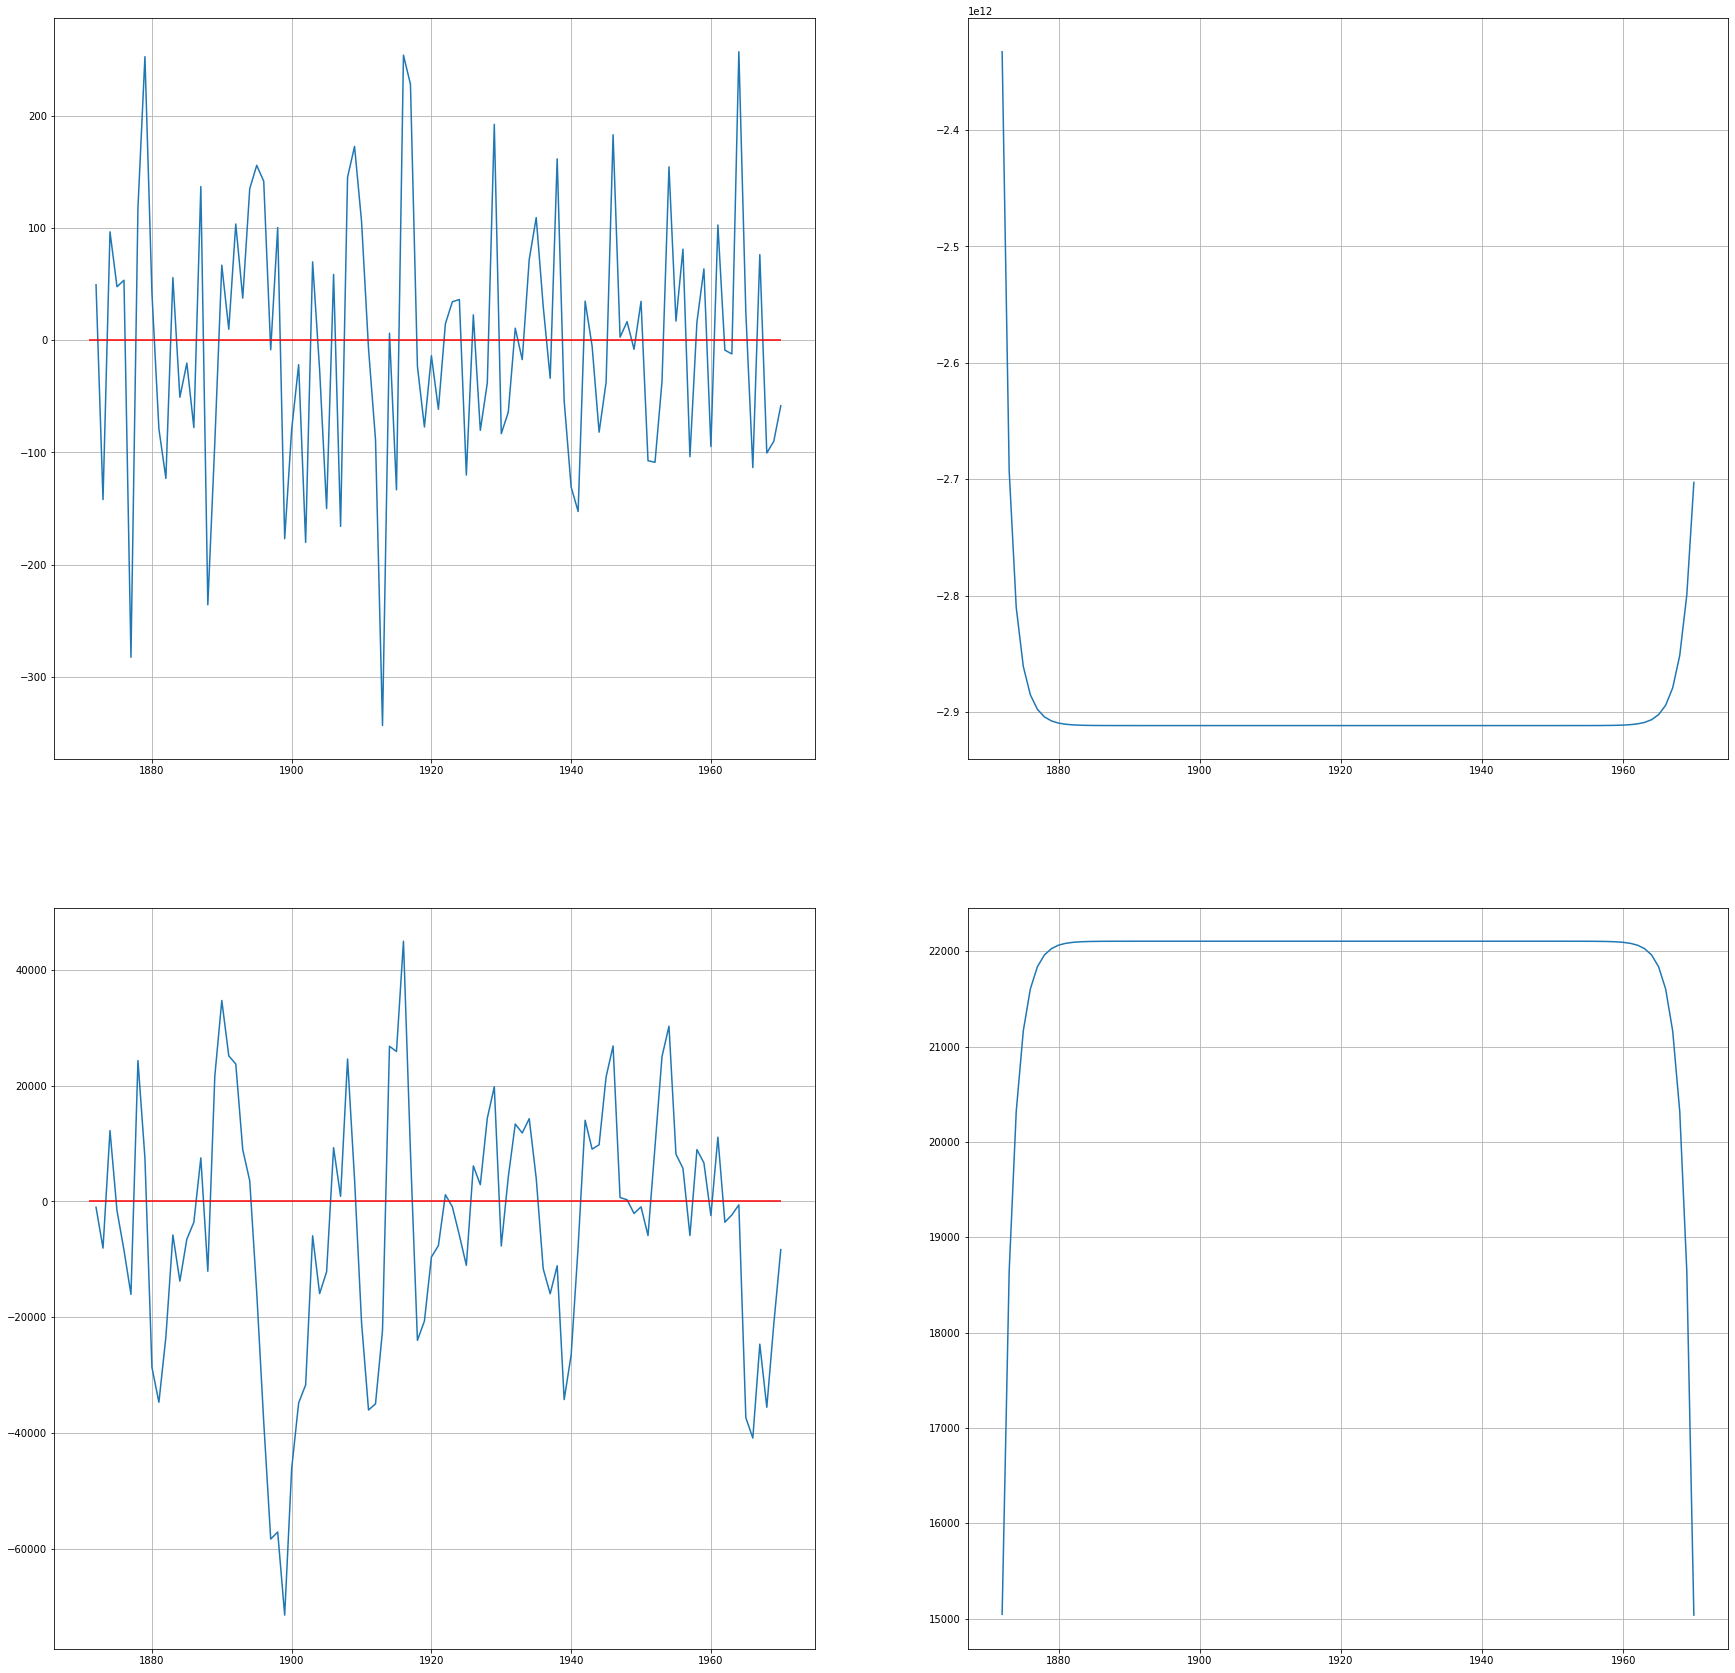

In [61]:
def dist_smoothing(df, P1, a1, sigma_e, sigma_n, r_int, N_int):

    df_kf = Kalman_filter(df, P1,a1,sigma_e, sigma_n)
    df_ks = Kalman_smoother(df, P1, a1, sigma_e, sigma_n, r_int, N_int)
    df_ds = pd.DataFrame(columns=['eps', 'n', 'var_eps', 'var_n'])

    #df_ks = df_ks.iloc[::-1].reset_index(drop=True)

    for i in range(len(df_ks)):

        eps = df_ks.Nile[i] - df_ks.alpha[i]

        D = df_kf.F[i]**(-1) + df_kf.K[i]**(2) * df_ks.N[i]
        var_eps = sigma_e**2 - (sigma_e**4 * D)
        var_n = sigma_n**2 - sigma_n**4 * df_ks.N[i]
        
        n = sigma_n**2 * df_ks.r[i]
        row = [eps, n, var_eps, var_n]

        df_ds.loc[i] = row

    df_ds['year'] = df_ks['year']
    df_ds['Nile'] = df_ks.Nile

    return df_ds

df_ds = dist_smoothing(df=df, P1=1e7, a1=0, sigma_e=15099, sigma_n=1469.1, r_int=0, N_int=0)
df_ds
fig, axs = plt.subplots(2,2, figsize=(30,30))

# upper left
ax = axs[0,0]
ax.plot(df_ds['year'], df_ds['eps'])
ax.hlines(y = 0, xmin= df['year'].min(), xmax=df['year'].max(), color = 'r', linestyle = '-')

# lower left
ax = axs[1,0]
ax.plot(df_ds['year'][:], df_ds['n'][:])
ax.hlines(y = 0, xmin= df['year'].min(), xmax=df['year'].max(), color = 'r', linestyle = '-')

# upper right
ax = axs[0,1]
ax.plot(df_ds['year'][:], df_ds['var_eps'][:])


# lower right
ax = axs[1,1]
ax.plot(df_ds['year'][:], df_ds['var_n'][:])

# make nice plot
for row in axs:
    for ax in row:
        ax.grid()
        pass


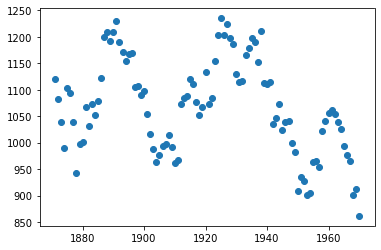

In [68]:
def llm_sim(df, P1, a1, sigma_e, sigma_n, r_int, N_int, a1_plus):

    df_kf = Kalman_filter(df, P1, a1, sigma_e, sigma_n)
    df_ks = Kalman_smoother(df, P1, a1, sigma_e, sigma_n, r_int, N_int)
    df_ds = dist_smoothing(df, P1, a1, sigma_e, sigma_n, r_int, N_int)

    a = a1_plus

    df_llm = pd.DataFrame(columns=['y_sim', 'alpha_plus', 'alpha_kringeltje'])

    for i in range(len(df)):

        eps = np.random.randn()*(sigma_e**0.5)
        n = np.random.randn()*(sigma_n**0.5)

        y = a + eps

        eps_kringeltje = eps - 
        alpha_kringeltje = df.Nile[i] - eps_kringeltje

        row = [y, a, alpha_kringeltje]
        df_llm.loc[i] = row

        a = a + n

    return df_llm

df_llm = llm_sim(df=df, P1=1e7, a1=0, sigma_e=15099, sigma_n=1469.1, r_int=0, N_int=0, a1_plus=df.Nile[0])


        

In [69]:
print('kf', df_kf.columns)
print('ks', df_ks.columns)
print('ds',df_ds.columns)

kf Index(['a', 'P', 'v', 'F', 'K', 'ci', 'year', 'Nile'], dtype='object')
ks Index(['r', 'alpha', 'N', 'V', 'err', 'year', 'Nile'], dtype='object')
ds Index(['eps', 'n', 'var_eps', 'var_n', 'year', 'Nile'], dtype='object')


In [70]:
df_ks

,r,alpha,N,V,err,year,Nile
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.000470,1110.529257,0.000049,3242.056999,56.939064,1872.0,1160.0
2,-0.003747,1105.024860,0.000075,2818.473138,53.089294,1873.0,963.0
3,0.005659,1113.339175,0.000089,2590.916003,50.901041,1874.0,1210.0
4,-0.000742,1112.248601,0.000096,2468.668074,49.685693,1875.0,1160.0
...,...,...,...,...,...,...,...
95,-0.018950,859.504467,0.000100,2468.803438,49.687055,1966.0,746.0
96,-0.011433,842.708974,0.000096,2591.167976,50.903516,1967.0,919.0
97,-0.016485,818.490529,0.000089,2818.942170,53.093711,1968.0,718.0
98,-0.009830,804.049596,0.000075,3242.930073,56.946730,1969.0,714.0
